<a href="https://colab.research.google.com/github/skywalker290/Image-Classification-Model/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐕 End-to-End Multil-class Dog Class bread classification

This notebook builds an end-to-end muti-class image classfier using tensorflow 2.0 and Tensorflow hub

## 1. Problem

Identifying  the breed of a dog given an image of the dog.

## 2. Data

The data we are using is from kaggle dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilties for each dog breed of each test image.
https://www.kaggle.com/c/dog-breed-identification/data

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/ Transfer Learning.
* There are 120 Breads of dogs(120 diffrent class). with labels
* There are around 10000+ Images in Training and testing set. no labels






### Initial Credentials Setup

In [2]:
# Initial Credetials Setup
!mkdir /root/.kaggle
!echo "{"username":"skywalker290","key":"f98d8b5f743369ea5729ca5703404104"}" > /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.jsonk

import os

os.environ['KAGGLE_USERNAME'] = 'skywalker290'
os.environ['KAGGLE_KEY'] = 'f98d8b5f743369ea5729ca5703404104'



mkdir: cannot create directory ‘/root/.kaggle’: File exists
{username:skywalker290,key:f98d8b5f743369ea5729ca5703404104}
chmod: cannot access '/root/.kaggle/kaggle.jsonk': No such file or directory


In [4]:
# Downloading data
!kaggle competitions download -c dog-breed-identification
!mkdir data
!unzip dog-breed-identification.zip -d data/


dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data’: File exists
Archive:  dog-breed-identification.zip
replace data/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Getting Workspace Ready

* Import Tensorflow 2.x
* Import Tensorflow Hub
* Make sure we're using GPU



In [5]:
# Import Tensorflow into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("Tensflow version:",tf.__version__)
print("Tensflow_hub version:",hub.__version__)

# Check for GPU availability
print("GPU","available (YESSS!!!!!!!!!!)" if tf.config.list_physical_devices("GPU") else "Not avaialble :(")

Tensflow version: 2.15.0
Tensflow_hub version: 0.15.0
GPU available (YESSS!!!!!!!!!!)


## Getting Our data ready(Turning into tensors)

with all the  machine learning  models, our data  has to be in numerical format. So that's what we'll be doing first. Turning our images  into tensors
(numerical representations).

In [6]:
# check out the labels of our data
import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

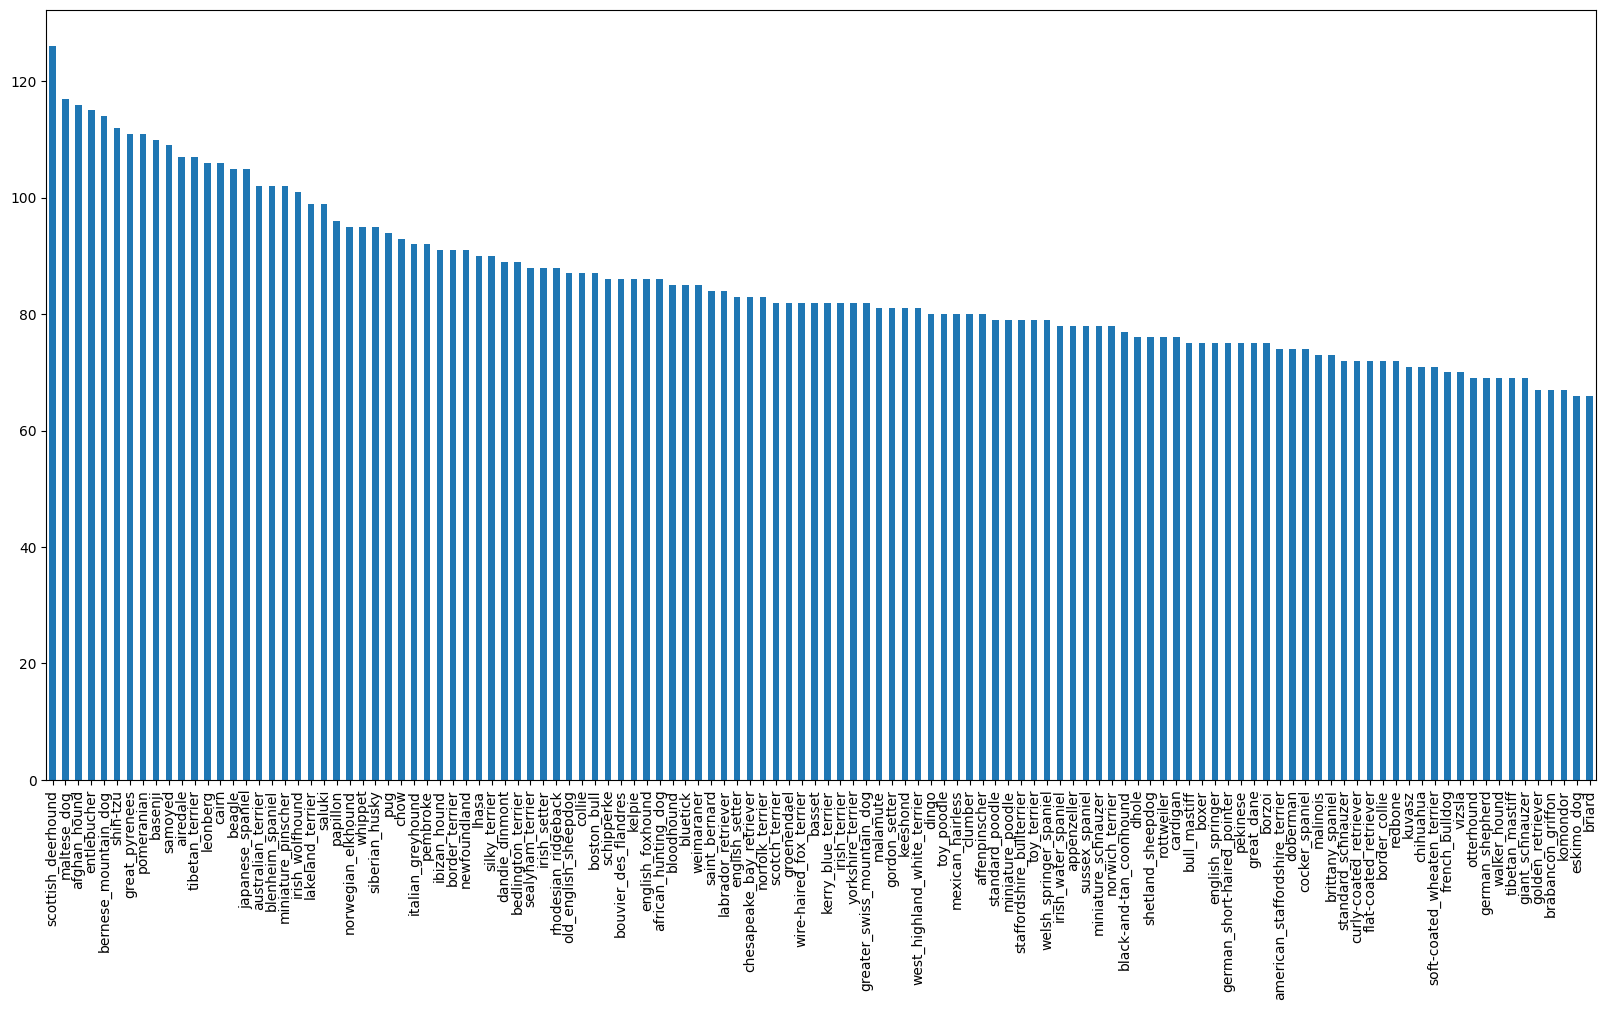

In [7]:
# lets see how many diffrent images do we have for a breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [8]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

In [9]:
!pip install IPython

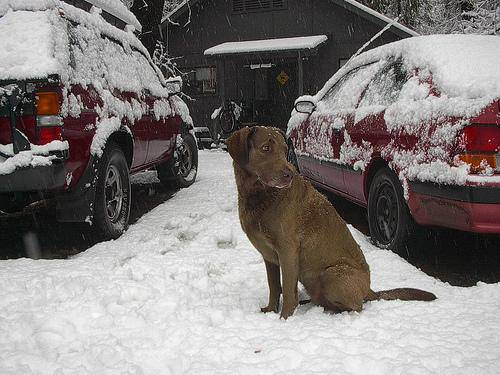

In [10]:
 # lets view an image
 from IPython.display import Image
 Image("data/train/fff43b07992508bc822f33d8ffd902ae.jpg")

### Getting images and their labels

lets get a list of all of our image file pathnames

In [11]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
# create pathnames from image ID's
filenames = [ "data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("data/train/"))==len(filenames):
  print("Filenames match actal amount of files!!! Proceed.")
else :
  print(("Filenames do not match"))

Filenames match actal amount of files!!! Proceed.


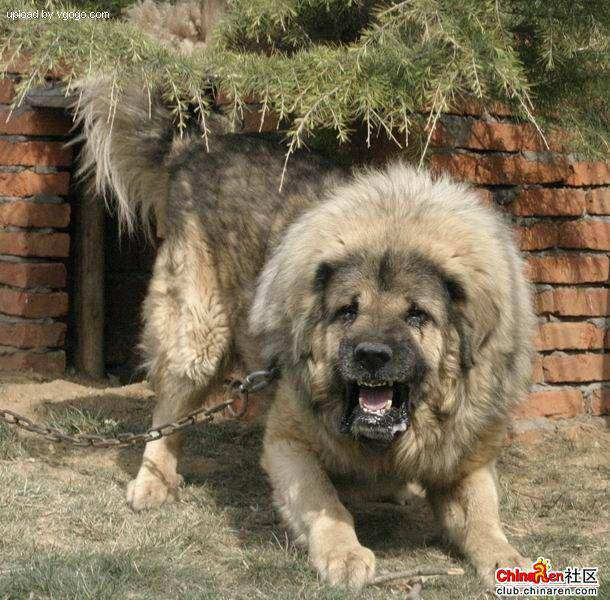

In [14]:
# One more check
Image(filenames[9000])

In [15]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, lets prepare our labels.

In [16]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
len(labels)

10222

In [18]:
 # see if number of labels matches the number of filenames

if len(labels)== len(filenames):
  print("Match")
else :
  print("Do not match")

Match


In [19]:
# find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [20]:
len(unique_breeds)# we have 120 breeds of dogs both in data set and here

120

In [21]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds


boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# turn every label inot boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
boolean_labels[0].astype(int) # To print all the data in form of zeros and ones

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Creating our own validation set
since the dataset from kaggle doesnt come with validation set so we are gonna create one of our own.
😎

In [24]:
# setup X and Y variables;
X = filenames
y = boolean_labels

In [25]:
len(filenames)

10222

We are gonna work on 10K+ Images so we aint gonna work on the whole we will take 1K first and then go with the whole bunch later.

Now this is some cool shit.
:)

In [26]:
# Set Number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,max:10222,step:1000}

In [27]:
# lets split of the data for train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],random_state=42,test_size=0.2)

# check the shape of data
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [28]:
X_train[:5],(y_train[:5])

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False

## Preprocessing Images(Turning Images into Tensors)
To preprocess images we gonna write a function which does few things:
1. Take a image filepath as input
2. Make tensorflow read the 'image' and save it into a variable
3. Turn our Jpg images into tensors.
4. Resize the image to a standard size (224,224)
5. return the modified image


Before we do, lets see what importing and image looks like.

In [29]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [30]:
image.max(), image.min()

(255, 0)

In [31]:
# lets turn this into a tensor
# we can convert almost anything into a tensor using this
# Benifit: it can run on GPU so gpu can find patterns in this lot faster than our cpu
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, lets make a function to preprocess them.
1. Take a image filepath as input
2. Make tensorflow read the 'image' and save it into a variable
3. Turn our Jpg images into tensors.
4. Normalise our image convert colour channel values 0-255 to 0-1
5. Resize the image to a standard size (224,224)
6. return the modified image


In [32]:
# Define Image size
IMG_SIZE=224

# create a function for preprocesssing images
def process_image(image_path,img_size=IMG_SIZE):
  """
  Takes image path and turns image into tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # turn jpg image into numerical tensor with 3 colour channels(red,green,blue)
  image = tf.image.decode_jpeg(image,channels=3)
  # convert RGB values 0-255 to values 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image to desired size (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  return image


Tensorflow likes the data in form of batches.
what is batches now?it is also called a mini batch a small portion of your data
Yann LeCun Batch Size = 32,
jeremy howard.

---


**Yenn Lecun, Jeremy Howard are one of the best ML and AI experts**

## Turning our data into batches

why turn our data into batches?
lets say you're trying to process 10000+ images in one go... they all might not fit into memory.

->so thats why we do about 32 images at a time(batch size can be manually adjusted if needed be).

->In order to use tensorflow effectively we need our data in form of tensorflow tuples which look like this:
`(image ,label)`.



In [59]:
# create a simple functon to return a tuple
def get_image_label(image_path,label):
  """
  Take image path and label and the associated labels, processs the image and returns the tuple of image,label
  """
  image = process_image(image_path)
  return image,label

In [60]:
# Demo of the above
get_image_label(X[42],y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of tensors in the form: `(image,label)`, lets make function to turn all of our data (X & Y) into batches.

In [79]:
# define a batch size
BATCH_SIZE = 32

# lets create a fucntion to create batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of images X and labels Y pairs,
  shuffles the data if its a training data
  doesn't shuffle if its validation data
  Also accept test data as input(No labels).
  """

  # if the data is test dataset we probably dont have labels
  if test_data:
      print("Creating Test data Batches....")
      data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths (no labels)
      data_batch = data.map(process_image).batch(BATCH_SIZE)# this maps the dataslices with process image function and create batches
      return data_batch


  # if data is a validation data
  elif valid_data:
    print("Creating Validation Data Batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),# Filepaths
                                               tf.constant(y)))# Labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch



  else:
    print("Creating Training Data Batches....")
    data= tf.data.Dataset.from_tensor_slices((tf.constant(x), #Filepaths
                                             tf.constant(y)))  # Labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # create (image,label) tuples (this also turn the image path into a preprocessed image)
    data_batch = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch




In [80]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [81]:
# Create training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val, valid_data=True)


Creating training data batches...
Creating validation data batches...


In [82]:
# lets check out the diffrent attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))